In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [31]:
df = pd.read_csv('TSLA_Intra_Export.csv')
df.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2020-03-13 09:45:00,600.370,607.5700,566.1900,571.3700,2485924.0
1,2020-03-13 10:00:00,572.970,573.2500,553.7800,562.3200,1161212.0
2,2020-03-13 10:15:00,562.394,574.3097,562.3462,563.2658,637325.0
3,2020-03-13 10:30:00,563.360,572.0000,562.1800,568.5900,661328.0
4,2020-03-13 10:45:00,568.610,572.3000,560.0000,560.0100,476198.0


In [32]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['4. close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['4. close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,571.370000,571.370000,NaN
1,0.0,566.845000,566.845000,0.0
2,0.0,565.651933,565.651933,0.0
3,0.0,566.386450,566.386450,0.0
4,0.0,565.111160,565.111160,0.0
...,...,...,...,...
775,0.0,713.710063,714.583262,0.0
776,0.0,714.317958,714.551467,0.0
777,1.0,714.739737,714.545936,1.0
778,1.0,715.493953,714.542092,0.0


In [0]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [34]:
states_buy, states_sell, total_gains, invest = buy_stock(df['4. close'], signals['positions'])

day 114: buy 1 units at price 407.221500, total balance 9592.778500
day 156, sell 1 units at price 422.740000, investment 3.810825 %, total balance 10015.518500,
day 183: buy 1 units at price 484.320000, total balance 9531.198500
day 248, sell 1 units at price 521.001100, investment 7.573732 %, total balance 10052.199600,
day 290: buy 1 units at price 502.580000, total balance 9549.619600
day 302, sell 1 units at price 506.000000, investment 0.680489 %, total balance 10055.619600,
day 314: buy 1 units at price 536.740000, total balance 9518.879600
day 343, sell 1 units at price 507.060000, investment -5.529679 %, total balance 10025.939600,
day 401: buy 1 units at price 479.835000, total balance 9546.104600
day 478, sell 1 units at price 545.727700, investment 13.732366 %, total balance 10091.832300,
day 494: buy 1 units at price 574.017500, total balance 9517.814800
day 584, sell 1 units at price 723.660000, investment 26.069327 %, total balance 10241.474800,
day 588: buy 1 units at p

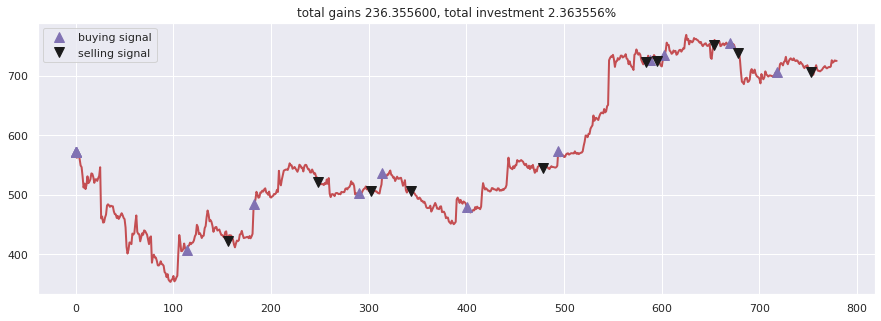

In [35]:
close = df['4. close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()